In [1]:
#####################################
# Libraries
#####################################
# Common libs
import pandas as pd
import numpy as np
import sys
import os
import random
from pathlib import Path

# Image processing
import imageio
import skimage
import skimage.io
import skimage.transform
#from skimage.transform import rescale, resize, downscale_local_mean

# Charts
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns


# ML
import scipy
from sklearn.model_selection import train_test_split
from sklearn import metrics

#from sklearn.preprocessing import OneHotEncoder
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization,LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
import tensorflow

#####################################
# Settings
#####################################

# Set random seed to make results reproducable
np.random.seed(42)
tensorflow.set_random_seed(42)

# Global variables
img_folder='../input/bee_imgs/'
img_width=100
img_height=100
img_channels=3

Using TensorFlow backend.


# Прочитаем входные данные 
Читаем датасет и сами изображения + создадим функцию для отрисовки изображений, которую будем использовать чуть позже

file Имя файла
date Дата съемки
time Время съемки
location Место
zip code Почтовый индекс
subspecies Подвиды медоносных пчел
health Здоровье пчелы
pollen_carrying Присутствие пыльцы на лапках
caste Worker, Drone, or Queen bee (Рабочий, трутень, королева)


In [3]:
bees=pd.read_csv('../input/bee_data.csv', 
                index_col=False,  
                parse_dates={'datetime':[1,2]},
                dtype={'subspecies':'category', 'health':'category','caste':'category'})
bees.head()

,datetime,file,location,zip code,subspecies,health,pollen_carrying,caste
0,2018-08-28 16:07:00,041_066.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
1,2018-08-28 16:07:00,041_072.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
2,2018-08-28 16:07:00,041_073.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
3,2018-08-28 16:07:00,041_067.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
4,2018-08-28 16:07:00,041_059.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker


In [4]:
# Will use this function later to load images of preprocessed bees
# Don't load images just from the start to save memory for preprocessing steps
def read_img(file):
    """
    Read and resize img, adjust channels. 
    Caution: This function is not independent, it uses global vars: img_folder, img_channels
    @param file: file name without full path
    """
    img = skimage.io.imread(img_folder + file)
    img = skimage.transform.resize(img, (img_width, img_height), mode='reflect')
    return img[:,:,:img_channels]

In [5]:
# Исключаем строки с NaN-значениями
bees.dropna(inplace=True)

# Исключаем строки без изображений
img_exists = bees['file'].apply(lambda f: os.path.exists(img_folder + f))
bees = bees[img_exists]

bees.head()

,datetime,file,location,zip code,subspecies,health,pollen_carrying,caste
0,2018-08-28 16:07:00,041_066.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
1,2018-08-28 16:07:00,041_072.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
2,2018-08-28 16:07:00,041_073.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
3,2018-08-28 16:07:00,041_067.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
4,2018-08-28 16:07:00,041_059.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker


# Отобразим распределение данных

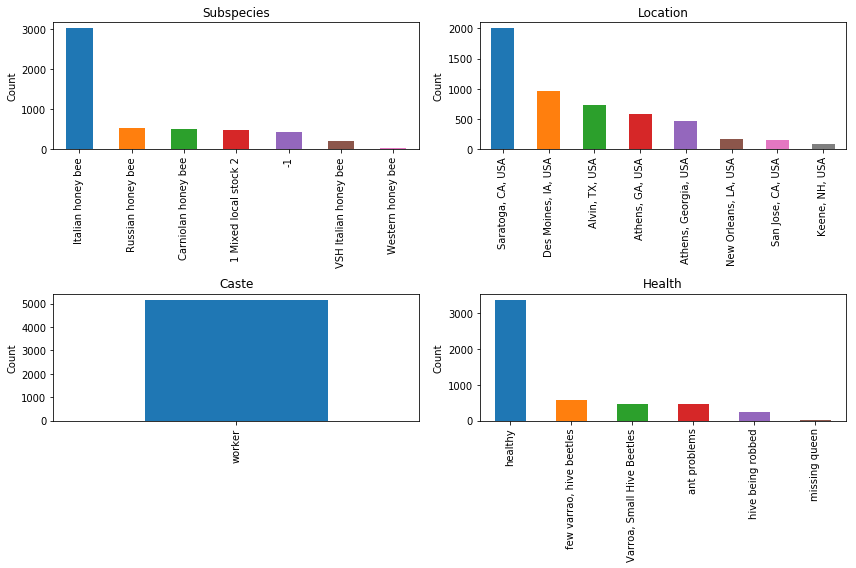

In [6]:
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
bees.subspecies.value_counts().plot(kind='bar',ax=ax[0, 0])
ax[0,0].set_ylabel('Count')
ax[0,0].set_title('Subspecies')

bees.location.value_counts().plot(kind='bar', ax=ax[0, 1])
ax[0,1].set_title('Location')
ax[0,1].set_ylabel('Count')

bees.caste.value_counts().plot(kind='bar', ax=ax[1, 0])
ax[1,0].set_title('Caste')
ax[1,0].set_ylabel('Count')

bees.health.value_counts().plot(kind='bar', ax=ax[1,1])
ax[1,1].set_title('Health')
ax[1,1].set_ylabel('Count')

f.subplots_adjust(hspace=0.7)
f.tight_layout()
plt.show()


## Виды пчел

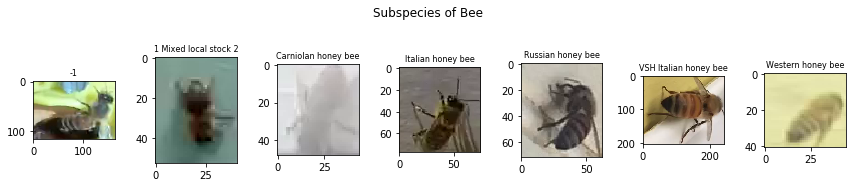

In [7]:
# Select first X subspecies titles 
subspecies = bees['subspecies'].cat.categories
f, ax = plt.subplots(nrows=1,ncols=subspecies.size, figsize=(12,3))
i=0
# Draw the first found bee of given subpecies
for s in subspecies:
    if s == 'healthy': continue
    file=img_folder + bees[bees['subspecies']==s].iloc[0]['file']
    im=imageio.imread(file)
    ax[i].imshow(im, resample=True)
    ax[i].set_title(s, fontsize=8)
    i+=1
    
plt.suptitle("Subspecies of Bee")
plt.tight_layout()
plt.show()

## Здоровые пчелы

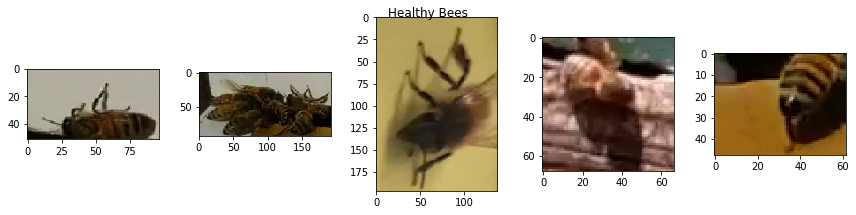

In [9]:
ncols = 5
healthy = bees[bees['health'] == 'healthy'].sample(ncols)

f, ax = plt.subplots(nrows=1,ncols=ncols, figsize=(12,3))
# Read image of original size from disk, because bees['img'] contains resized numpy array
for i in range(0,5): 
    file = img_folder + healthy.iloc[i]['file']
    ax[i].imshow(imageio.imread(file))

plt.suptitle("Healthy Bees")
plt.tight_layout()
plt.show()

## Больные пчелы

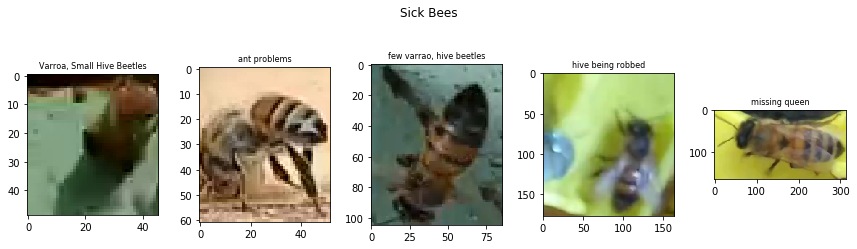

In [10]:
health_cats = bees['health'].cat.categories
f, ax = plt.subplots(1, health_cats.size-1, figsize=(12,4))
i=0
for c in health_cats:
    if c == 'healthy': continue
    bee = bees[bees['health'] == c].sample(1).iloc[0]
    ax[i].imshow(imageio.imread(img_folder + bee['file']))
    ax[i].set_title(bee['health'], fontsize=8)
    i += 1
    
plt.suptitle("Sick Bees")    
plt.tight_layout()
plt.show()

# Балансировка по подвиду

### Препроцессинг данных

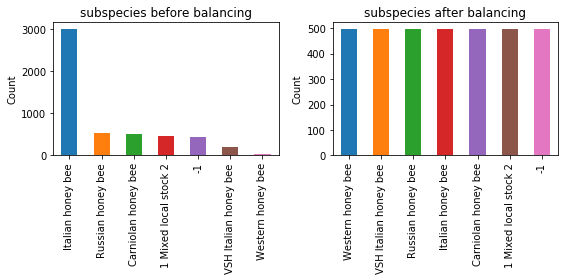

In [11]:
# The same split-balance idea will be used in 2 places: subspecies and health CNN.
# Let's put this logic in function here to reuse.
def split_balance(bees, field_name):
    """ 
    Split to train, test and validation. 
    Then balance train by given field name.
    Draw plots before and after balancing
    
    @param bees: Total Bees dataset to balance and split
    @param field_name: Field to balance by
    @return:  balanced train bees, validation bees, test bees
    """
    # Split to train and test before balancing
    train_bees, test_bees = train_test_split(bees, random_state=24)

    # Split train to train and validation datasets
    # Validation for use during learning
    train_bees, val_bees = train_test_split(train_bees, test_size=0.1, random_state=24)

    #Balance by subspecies to train_bees_bal_ss dataset
    # Number of samples in each category
    ncat_bal = int(len(train_bees)/train_bees[field_name].cat.categories.size)
    train_bees_bal = train_bees.groupby(field_name, as_index=False).apply(lambda g:  g.sample(ncat_bal, replace=True)).reset_index(drop=True)
    return(train_bees_bal, val_bees, test_bees)
    
def plot_balanced(train_bees, train_bees_bal, field_name):
    """
    Draw distribution of field by categories before and after balancing
    @param train_bees: before balancing
    @param train_bees_bal: after balancing
    @param field_name: balancing field
    """
    # Plot before and after balancing
    f, axs = plt.subplots(1,2, figsize=(8,4))

    # Before
    ax = train_bees[field_name].value_counts().plot(kind='bar', ax=axs[0])
    ax.set_title('%s before balancing' % field_name)
    ax.set_ylabel('Count')

    # After
    ax = train_bees_bal[field_name].value_counts().plot(kind='bar', ax=axs[1])
    ax.set_title('%s after balancing' % field_name)
    ax.set_ylabel('Count')

    plt.tight_layout()
    plt.show()

# Split/balance and plot the result
train_bees_bal, val_bees, test_bees = split_balance(bees, 'subspecies')
plot_balanced(bees, train_bees_bal, 'subspecies')

# Will use balanced dataset as main
train_bees = train_bees_bal

### Подготовка

Загружаем изображения и используем ImageDataGenerator для изменения изображений случайным образом (размер, поворот, смещение).

In [12]:
# The same way of loading images and one hot encoding will be used in 2 places: subspecies and health CNN.
# Let's put this logic in function here to reuse.
def prepare2train(train_bees, val_bees, test_bees, field_name):
    """
    Load images for features, drop other columns
    One hot encode for label, drop other columns
    @return: image generator, train images, validation images, test images, train labels, validation labels, test labels
    """
    # Bees already splitted to train, validation and test
    # Load and transform images to have equal width/height/channels. 
    # read_img function is defined in the beginning to use in both health and subspecies. 
    # Use np.stack to get NumPy array for CNN input

    # Train data
    train_X = np.stack(train_bees['file'].apply(read_img))
    train_y  = pd.get_dummies(train_bees[field_name], drop_first=False)

    # Validation during training data to calc val_loss metric
    val_X = np.stack(val_bees['file'].apply(read_img))
    val_y = pd.get_dummies(val_bees[field_name], drop_first=False)

    # Test data
    test_X = np.stack(test_bees['file'].apply(read_img))
    test_y = pd.get_dummies(test_bees[field_name], drop_first=False)

    # Data augmentation - a little bit rotate, zoom and shift input images.
    generator = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=180,  # randomly rotate images in the range (degrees, 0 to 180)
            zoom_range = 0.1, # Randomly zoom image 
            width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=True)
    generator.fit(train_X)
    return (generator, train_X, val_X, test_X, train_y, val_y, test_y)

#train_bees['subspecies'].cat.values[:-100]
# Call image preparation and one hot encoding
generator, train_X, val_X, test_X, train_y, val_y, test_y = prepare2train(train_bees, val_bees, test_bees, 'subspecies')

/home/endiny/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [16]:
# We'll stop training if no improvement after some epochs
earlystopper1 = EarlyStopping(monitor='loss', patience=10, verbose=1)

# Save the best model during the traning
checkpointer1 = ModelCheckpoint('best_model1.h5'
                                ,monitor='val_acc'
                                ,verbose=1
                                ,save_best_only=True
                                ,save_weights_only=True)
# Build CNN model
model1=Sequential()
model1.add(Conv2D(6, kernel_size=3, input_shape=(img_width, img_height,3), activation='relu', padding='same'))
model1.add(MaxPool2D(2))
model1.add(Conv2D(12, kernel_size=3, activation='relu', padding='same'))
model1.add(Flatten())
model1.add(Dense(train_y.columns.size, activation='softmax'))
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
training1 = model1.fit_generator(generator.flow(train_X,train_y, batch_size=60)
                        ,epochs=20
                        ,validation_data=[val_X, val_y]
                        ,steps_per_epoch=50
                        ,callbacks=[earlystopper1, checkpointer1])
# Get the best saved weights
model1.load_weights('best_model1.h5')

Epoch 1/20
50/50 [==============================] - 14s 288ms/step - loss: 1.4765 - acc: 0.4187 - val_loss: 1.2648 - val_acc: 0.4021

Epoch 00001: val_acc improved from -inf to 0.40206, saving model to best_model1.h5
Epoch 2/20
50/50 [==============================] - 14s 282ms/step - loss: 0.9397 - acc: 0.6360 - val_loss: 0.9672 - val_acc: 0.6495

Epoch 00002: val_acc improved from 0.40206 to 0.64948, saving model to best_model1.h5
Epoch 3/20
50/50 [==============================] - 14s 282ms/step - loss: 0.6305 - acc: 0.7979 - val_loss: 0.6865 - val_acc: 0.7320

Epoch 00003: val_acc improved from 0.64948 to 0.73196, saving model to best_model1.h5
Epoch 4/20
50/50 [==============================] - 14s 278ms/step - loss: 0.5009 - acc: 0.8356 - val_loss: 1.1546 - val_acc: 0.6289

Epoch 00004: val_acc did not improve from 0.73196
Epoch 5/20
50/50 [==============================] - 14s 278ms/step - loss: 0.4505 - acc: 0.8539 - val_loss: 0.9974 - val_acc: 0.6366

Epoch 00005: val_acc did 

### Оценка модели классификации подвидов пчел

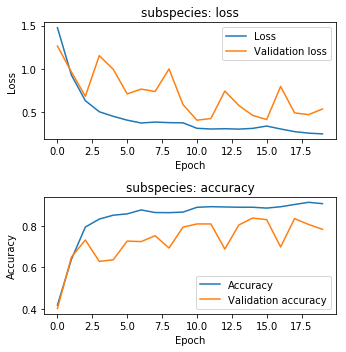

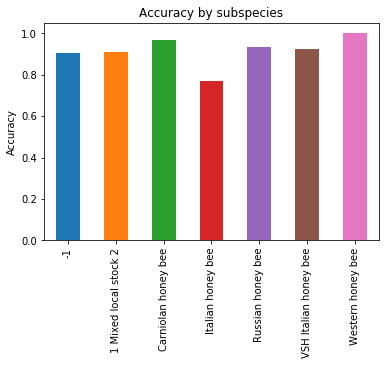

Classification report
                       precision    recall  f1-score   support

                   -1       0.81      0.94      0.87       108
1 Mixed local stock 2       0.45      0.91      0.61       102
  Carniolan honey bee       0.96      0.97      0.97       147
    Italian honey bee       0.98      0.79      0.87       754
    Russian honey bee       0.98      0.98      0.98       124
VSH Italian honey bee       0.66      0.96      0.78        54
    Western honey bee       1.00      1.00      1.00         4

            micro avg       0.86      0.86      0.86      1293
            macro avg       0.83      0.94      0.87      1293
         weighted avg       0.91      0.86      0.87      1293

Loss function: 0.3898620280478227, accuracy: 0.8576952823814457


In [17]:
# This is a function to use in Bee subspecies and health evaluation
def eval_model(training, model, test_X, test_y, field_name):
    """
    Model evaluation: plots, classification report
    @param training: model training history
    @param model: trained model
    @param test_X: features 
    @param test_y: labels
    @param field_name: label name to display on plots
    """
    ## Trained model analysis and evaluation
    f, ax = plt.subplots(2,1, figsize=(5,5))
    ax[0].plot(training.history['loss'], label="Loss")
    ax[0].plot(training.history['val_loss'], label="Validation loss")
    ax[0].set_title('%s: loss' % field_name)
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    
    # Accuracy
    ax[1].plot(training1.history['acc'], label="Accuracy")
    ax[1].plot(training1.history['val_acc'], label="Validation accuracy")
    ax[1].set_title('%s: accuracy' % field_name)
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    plt.tight_layout()
    plt.show()

    # Accuracy by subspecies
    test_pred = model.predict(test_X)
    
    acc_by_subspecies = np.logical_and((test_pred > 0.5), test_y).sum()/test_y.sum()
    acc_by_subspecies.plot(kind='bar', title='Accuracy by %s' % field_name)
    plt.ylabel('Accuracy')
    plt.show()

    # Print metrics
    print("Classification report")
    test_pred = np.argmax(test_pred, axis=1)
    test_truth = np.argmax(test_y.values, axis=1)
    print(metrics.classification_report(test_truth, test_pred, target_names=test_y.columns))

    # Loss function and accuracy
    test_res = model.evaluate(test_X, test_y.values, verbose=0)
    print('Loss function: %s, accuracy:' % test_res[0], test_res[1])

# Call evaluation function
eval_model(training1, model1, test_X, test_y, 'subspecies')

# Модель сверточной нейронной сети для классификации пчел по здоровья

## Препроцессинг данных для классификации пчел по здоровью

### Балансировка

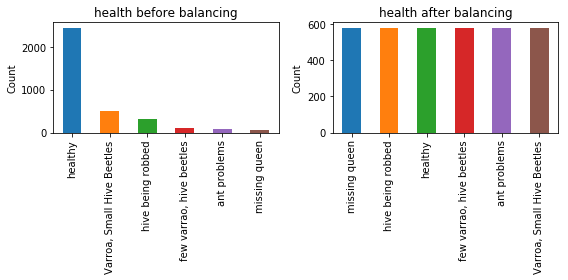

In [18]:
# Split/balance and plot the result
train_bees_bal, val_bees, test_bees = split_balance(bees, 'health')
plot_balanced(train_bees, train_bees_bal, 'health')

# Will use balanced dataset as main
train_bees_bal = train_bees

### Получим обучающее и тестовое множества для классификации по здоровью
Используя ранее объявленную функцию

In [20]:
generator, train_X, val_X, test_X, train_y, val_y, test_y = prepare2train(train_bees, val_bees, test_bees, 'health')

## Построение модели сверточной нейронной сети и обучение

In [23]:
# We'll stop training if no improvement after some epochs
earlystopper2 = EarlyStopping(monitor='val_acc', patience=10, verbose=1)

# Save the best model during the traning
checkpointer2 = ModelCheckpoint('best_model2.h5'
                                ,monitor='val_acc'
                                ,verbose=1
                                ,save_best_only=True
                                ,save_weights_only=True)
# Build CNN model
model2=Sequential()
model2.add(Conv2D(5, kernel_size=3, input_shape=(img_width, img_height,3), activation='relu', padding='same'))
model2.add(MaxPool2D(2))
model2.add(Conv2D(10, kernel_size=3, activation='relu', padding='same'))
model2.add(Flatten())
model2.add(Dense(train_y.columns.size, activation='softmax'))
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
training2 = model2.fit_generator(generator.flow(train_X,train_y, batch_size=60)
                        ,epochs=20
                        ,validation_data=[val_X, val_y]
                        ,steps_per_epoch=50
                        ,callbacks=[earlystopper2, checkpointer2])
# Get the best saved weights
model2.load_weights('best_model2.h5')

Epoch 1/20
50/50 [==============================] - 14s 274ms/step - loss: 0.7950 - acc: 0.7353 - val_loss: 1.0798 - val_acc: 0.6263

Epoch 00001: val_acc improved from -inf to 0.62629, saving model to best_model2.h5
Epoch 2/20
50/50 [==============================] - 13s 259ms/step - loss: 0.5646 - acc: 0.7954 - val_loss: 0.7966 - val_acc: 0.7062

Epoch 00002: val_acc improved from 0.62629 to 0.70619, saving model to best_model2.h5
Epoch 3/20
50/50 [==============================] - 13s 267ms/step - loss: 0.4744 - acc: 0.8394 - val_loss: 0.8373 - val_acc: 0.6778

Epoch 00003: val_acc did not improve from 0.70619
Epoch 4/20
50/50 [==============================] - 13s 264ms/step - loss: 0.4164 - acc: 0.8616 - val_loss: 0.7002 - val_acc: 0.7268

Epoch 00004: val_acc improved from 0.70619 to 0.72680, saving model to best_model2.h5
Epoch 5/20
50/50 [==============================] - 13s 263ms/step - loss: 0.3389 - acc: 0.8894 - val_loss: 0.5634 - val_acc: 0.7603

Epoch 00005: val_acc impr

### Оценка модели классификации здоровья пчел


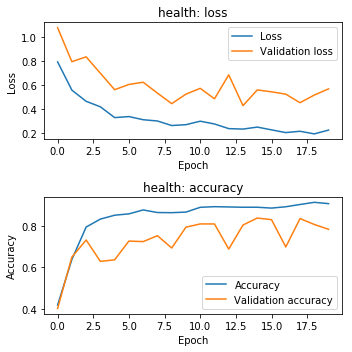

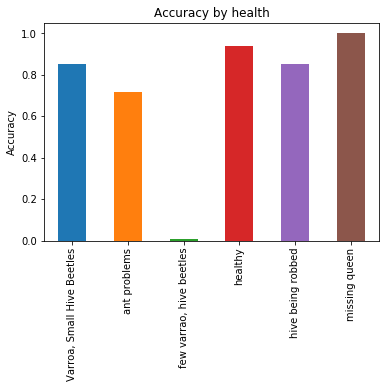

Classification report
                            precision    recall  f1-score   support

Varroa, Small Hive Beetles       0.48      0.90      0.63       102
              ant problems       0.99      0.75      0.85       117
  few varrao, hive beetles       0.38      0.04      0.08       139
                   healthy       0.92      0.96      0.94       866
         hive being robbed       0.59      0.85      0.70        61
             missing queen       0.73      1.00      0.84         8

                 micro avg       0.83      0.83      0.83      1293
                 macro avg       0.68      0.75      0.67      1293
              weighted avg       0.82      0.83      0.80      1293

Loss function: 0.3939912820959497, accuracy: 0.831399845320959


In [24]:
eval_model(training2, model2, test_X, test_y, 'health')

# Визуализация Conv2D слоев

Взглянем на промежуточные изображения обучения модели. Модель содержит Conv2D слои с ядрами внутри. Здесь мы "свернем" изображения сквозь эти ядра и посмотреть как оно выглядит до и после каждого ядра.
Визуализация ядра: само ядро, входное иозображение, выходное изображение.

In [26]:
# Common function for visualization of kernels
def visualize_layer_kernels(img, conv_layer, title):
    """
    Displays how input sample image looks after convolution by each kernel
    :param img: Sample image array
    :param conv_layer: Layer of Conv2D type
    :param title: Text to display on the top 
    """
    # Extract kernels from given layer
    weights1 = conv_layer.get_weights()
    kernels = weights1[0]
    kernels_num = kernels.shape[3]
    
    # Each row contains 3 images: kernel, input image, output image
    f, ax = plt.subplots(kernels_num, 3, figsize=(7, kernels_num*2))

    for i in range(0, kernels_num):
        # Get kernel from the layer and draw it
        kernel=kernels[:,:,:3,i]
        ax[i][0].imshow((kernel * 255).astype(np.uint8), vmin=0, vmax=255)
        ax[i][0].set_title("Kernel %d" % i, fontsize = 9)
        
        # Get and draw sample image from test data
        ax[i][1].imshow((img * 255).astype(np.uint8), vmin=0, vmax=255)
        ax[i][1].set_title("Before", fontsize=8)
        
        # Filtered image - apply convolution
        img_filt = scipy.ndimage.filters.convolve(img, kernel)
        ax[i][2].imshow((img_filt * 255).astype(np.uint8), vmin=0, vmax=255)
        ax[i][2].set_title("After", fontsize=8)
        
    plt.suptitle(title)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()

## Результаты работы слоёв свёртки по подвидам

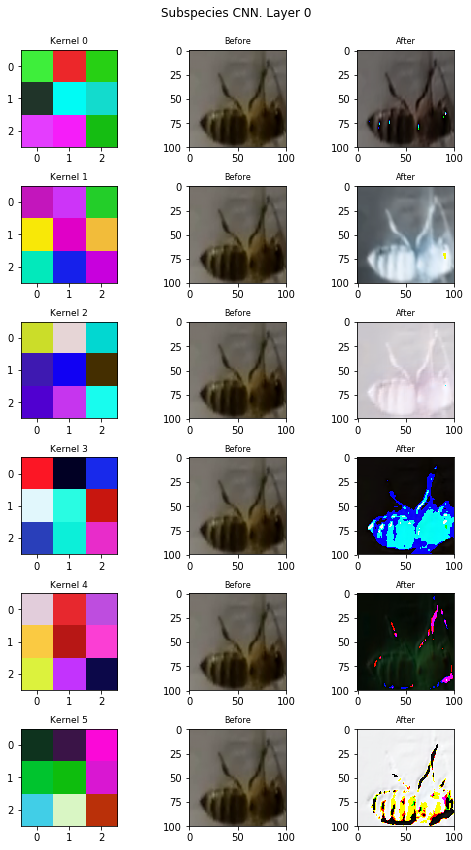

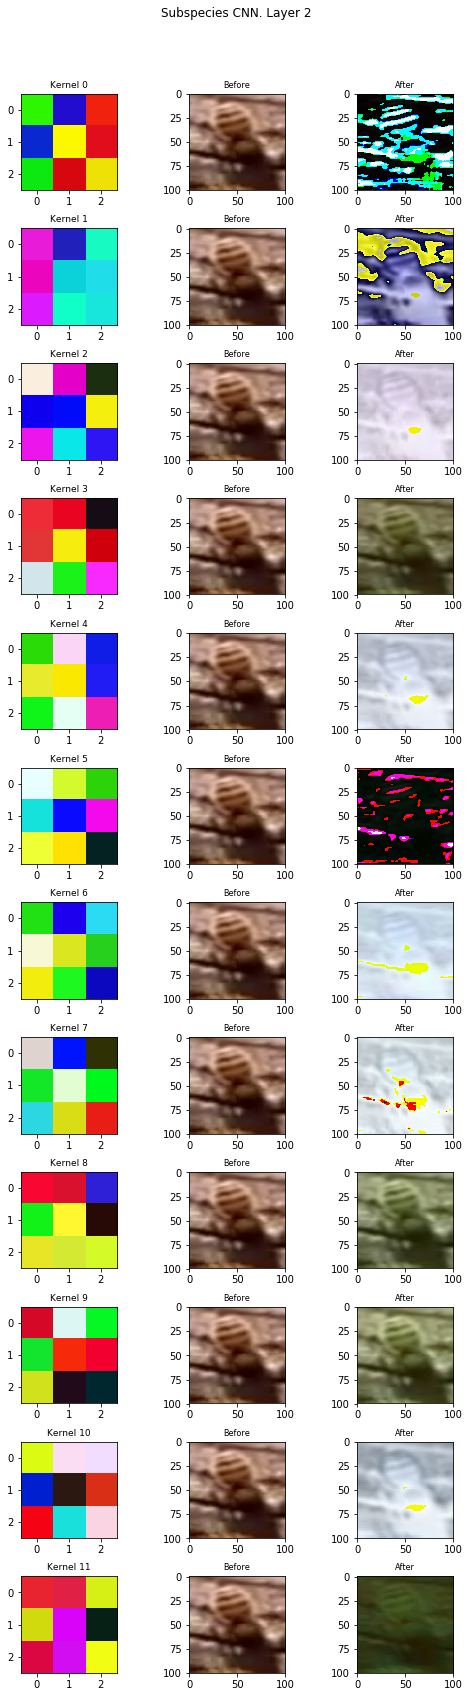

In [29]:
# Take sample image to visualize convolution
idx = random.randint(0,len(test_X)-1)
img = test_X[idx,:,:,:]
# Take 1st convolutional layer and look at it's filters
conv1 = model1.layers[0]
img = visualize_layer_kernels(img, conv1, "Subspecies CNN. Layer 0")

# Take sample image to visualize convolutoin
idx = random.randint(0,len(test_y)-1)
img = test_X[idx,:,:,:]
# Take another convolutional layer and look at it's filters
conv2 = model1.layers[2] 
res = visualize_layer_kernels(img, conv2, "Subspecies CNN. Layer 2")

## Результаты работы слоёв свёртки по здоровью

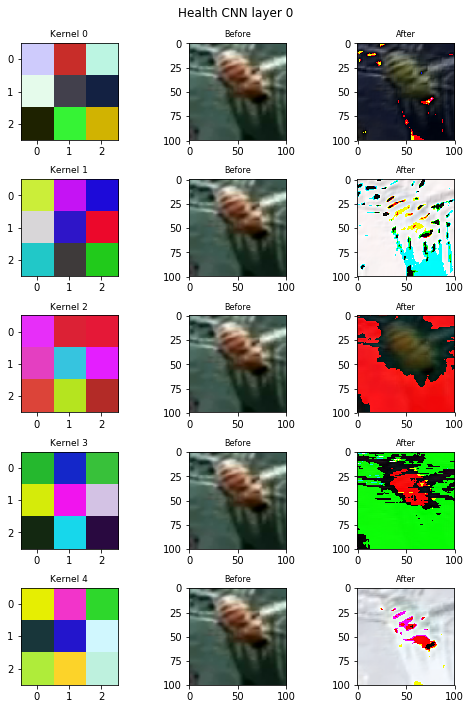

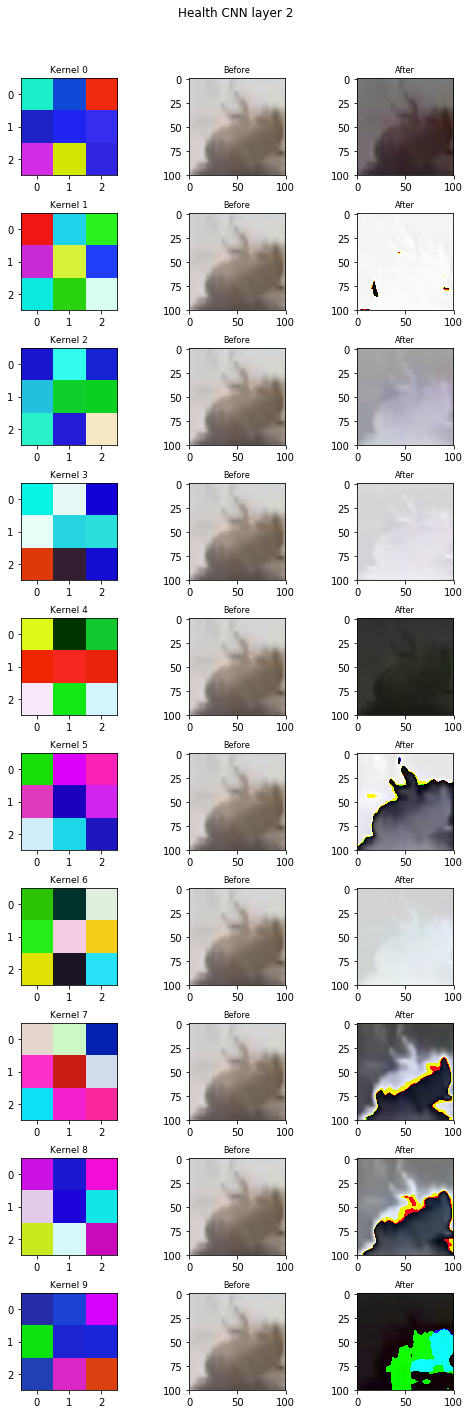

In [31]:
# Take sample image to visualize convolution
idx = random.randint(0,len(test_X)-1)
img = test_X[idx,:,:,:]
#img = img[:,:,:]
# Take 1st convolutional layer and look at it's filters
conv1 = model2.layers[0]
visualize_layer_kernels(img, conv1, "Health CNN layer 0")

# Take sample image to visualize convolutoin
idx = random.randint(0,len(test_X)-1)
img = test_X[idx,:,:,:]
# Take another convolutional layer and look at it's filters
conv2 = model2.layers[2]
visualize_layer_kernels(img, conv2, "Health CNN layer 2")